# Federated learning: deep learning for vertically partitioned data 

In this notebook, we provide a simple example of how to perform a **vertical** federated learning experiment with the help of the Sherpa.ai Federated Learning framework. 
As opposed to the horizontal federated learning paradigm, in a vertical federated learning setting (see e.g. [Federated Machine Learning: Concept and Applications](https://arxiv.org/abs/1902.04885)) the different nodes possess the same samples, but different features. 
A practical example being that of a local on-line shop and an insurance company: both entities might have matching customers (samples), but the information (features) each entity possesses about the customers is of different nature. 
We are going to use a synthetic dataset and a neural network model.


## The data
We use `sklearn` module for generating synthetic databases. 
Moreover, in order to simulate a vertically partitioned training data, we randomly split the features of the created dataset among the clients:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from shfl.private.reproducibility import Reproducibility

# Comment to turn off reproducibility:
#Reproducibility(567)

# Create dataset
n_features = 20
n_classes = 2
n_samples = 15000

x, y = make_classification(
    n_samples=n_samples, n_features=n_features, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, flip_y=0.1, class_sep=0.4, random_state=123)

**Vertical split of the dataset.** In the vertical FL setting, the database is split along the columns (i.e., vertically) among the nodes. 
We can use a method provided by the Sherpa FL Framework to randomly split a dataset vertically into the desired number of parts: 

In [2]:
from shfl.data_base.data_base import vertical_split

# Create a vertically split dataset: split the features among clients
M = 2  # number of clients
x_train_client, train_labels, x_test_client, test_labels = \
vertical_split(data=pd.DataFrame(x), labels=pd.DataFrame(y), n_chunks=M, shuffle_data=False)
for key in x_train_client:
    print("Client " + str(key) + " train data shape: " + str(x_train_client[key].shape))


Client 0 train data shape: (12000, 11)
Client 1 train data shape: (12000, 9)


**Wrap into FederatedData.** At this point, we assign the data to a federated network of clients. 
Since the clients actually don't possess the labels (only the server does), we assign the client's labels to `None`. 
And since we already performed the split of data for each client, we just use `PlainDataDistribution` to create the wrapper for the federated data (this class converts the data "as is" into a `FederatedData` object):

In [3]:
# Make federated data: 
from shfl.data_base.data_base import LabeledDatabase
from shfl.data_distribution.data_distribution_plain import PlainDataDistribution

train_labels_client = {0:None, 1:None}
data_base = LabeledDatabase(data=x_train_client, 
                            labels=train_labels_client, 
                            train_percentage=1., 
                            shuffle_data=False) 

federated_data, _, _ = PlainDataDistribution(database=data_base).get_federated_data()
print(federated_data)

**Federated transformation.** In case we need to perform a data transformation on all the clients of the federated data, this is easily achieved by the framework's method: 

In [4]:
# Federated data operation: need to transpose
from shfl.private import FederatedTransformation

class Transpose(FederatedTransformation):
    
    def apply(self, labeled_data):
        if labeled_data.data is not None:
            labeled_data.data = labeled_data.data.T
        
federated_data.apply_data_transformation(Transpose());

In order to visually check everything went fine with the data assignment, we can configure data access to node (otherwise protected by default):

In [5]:
# Check federated data:
from shfl.private.data import UnprotectedAccess

federated_data.configure_data_access(UnprotectedAccess());
federated_data[0].query()
#federated_data[1].query().data
#federated_data[0].query().label

## The model:

**Horizontal Vs Vertical Federated Learning.** Both in the  Federated Government is interpreted as follows: 
 - The Federated Government is intended as a *Coordinator*: it defines and schedules the federated computations, but does not have any other function (no data, no model). It is what a user can customize for the specific case problem.
 - The Federated Data is composed by nodes that can have multiple functions: train, store data, aggregate, make auxiliary computations, predictions etc.
 - In particular, the Server is itself a *node* that can interact with the Federated Data: it might aggregate, but might also contain data and train on them

In Horizontal FL (see e.g. the [basic concepts notebook](./federated_learning_basic_concepts.ipynb)), all nodes have typically the same model, and the server node has also the aggregation function in its model as an attribute but do not train and does not possess any data.
Instead in a Vertical FL architecture, the client nodes might have a *different model* with respect each other and with respect the server node.
The latter in turn can aggregate, train and might possess its own data (i.e. the labels in this case).

Note that the distinction between client and server is *only virtual* and not necessarily physical, since a single node might be both client and server, allowing multiple roles for the same physical node.   

**Define the server node.** We said that in the Vertical FL, each node, including the server, is allowed to possess a different model and different methods for interacting with the clients.
We here define the server model with specific functions needed for the present Vertical FL architecture: 

In [6]:
from shfl.federated_government.vertical_federated_deep_learning import FederatedGovernmentVertical
from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient
from shfl.model.vertical_deep_learning_model import VerticalLogLinearServer
from shfl.private.federated_operation import FederatedDataNode


class VerticalServerDataNode(FederatedDataNode):
    """
        This class represents a type Server [DataNode](../data_node) in a FederatedData.
        Extends DataNode allowing calls to methods without explicit private data identifier,
        assuming access to the Server's data (if any).
        Aggregate weights from all data nodes in the server model and
        updates the server. In this vertical architecture, the server possesses part
        of the model, thus the aggregation is actually a server's training.
        It supports Adaptive Differential Privacy through Privacy Filters

        # Arguments:
            federated_data: the set of client nodes
            model: python object representing the model of the server node
            aggregator: python object representing the type of aggregator to use
            data: optional, server's private data
        """

    def __init__(self, federated_data, model, aggregator, data=None):
        super().__init__(federated_data_identifier=str(id(federated_data)))
        self._federated_data = federated_data
        self.model = model
        self._aggregator = aggregator
        self.set_private_data(data)
        
    
    def aggregate_weights(self):
        
        embeddings = [data_node.query_model()
                      for data_node in self._federated_data]
        
        self.train_model(embeddings=embeddings)
        
    def compute_loss(self):
        """
        Evaluate loss on the train set.
        """
        embeddings = [data_node.query_model()
                      for data_node in self._federated_data]
        
        loss = self.query(server_node=self, embeddings=embeddings)
        
    def evaluate_collaborative_model(self, data_test, label_test):
        """
        Evaluation of the performance of the collaborative model.

        # Arguments:
            test_data: test dataset (global)
            test_label: corresponding labels to test dataset
        """

        # Compute embeddings (CLIENTS)
        embeddings = [data_node.predict(data_test[data_node_key])
                      for data_node, data_node_key in
                      zip(self._federated_data, data_test.keys())]

        # Compute prediction (SERVER)
        prediction = self.predict(embeddings)
        print("Distributed model test AUC: "
              + str(self.performance(prediction, label_test)))

        return prediction
        

**Define specific data access needed for the Vertical FL round.** The specific Vertical FL architecture requires the computation of the Loss and the exchange of convergence parameters. 
Namely, the clients send the computed embeddings to the server, and the server sends the computed gradients to update the clients. 
Therefore, we define ad-hoc access definitions for these methods, and we assign them to server and clients: 

In [9]:
from shfl.private.data import DataAccessDefinition

class ComputeLoss(DataAccessDefinition):
    def apply(self, data, **kwargs): 
        embeddings = kwargs.get("embeddings")
        node = kwargs.get("server_node")
        loss = server_node._model.compute_loss(
                embeddings, data.label)
        
        print("Collaborative model train loss: " + str(loss))
        
        return loss
    
    
class QueryMetaParameters(DataAccessDefinition):
    def apply(self, model):
        """Returns embeddings (or their gradients) as computed by the local model."""
        return model.get_meta_params()

    
# Configure data access to nodes and server
federated_data.configure_model_access(QueryMetaParameters())
server_node.configure_model_access(QueryMetaParameters())
server_node.configure_data_access(ComputeLoss())   

print(federated_data[1]._model_access_policy)
print(server_node._model_access_policy)
print(server_node._private_data_access_policies)

## Run the federated learning experiment

We are almost done: we only need to specify which specific model to use for each client node, and the server node. 
Namely, the clients will run a neural network model, but of course they will have different input size since they possess different number of features. 
We first don't use hidden layers for the clients model, resulting in a *linear* model (`layer_dims=None` parameter).
The server is assigned a linear model, along with the data to train on (labels): 

In [7]:
from shfl.private.data import LabeledData


server_node = VerticalServerDataNode(
        federated_data=federated_data, 
        model=VerticalLogLinearServer(), 
        aggregator=None,
        data=LabeledData(None, train_labels[0].values))

model_nodes = [VerticalNeuralNetClient(n_features=x_train_client[0].shape[1], layer_dims=None),
               VerticalNeuralNetClient(n_features=x_train_client[1].shape[1]), layer_dims=None]

In [10]:
# Create federated government and run training:

federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

x_test_client_transpose = {i: x_test_client[i].T for i in range(len(x_test_client))}
federated_government.run_rounds(n=20001, 
                                test_data=x_test_client_transpose, 
                                test_label=test_labels[0].values, 
                                print_freq=1000)

Round 0
Collaborative model train loss: 0.7051183045476347
Distributed model test AUC: 0.5607513230288127


Round 1000
Collaborative model train loss: 0.6456538245204053
Distributed model test AUC: 0.7000210226800494


Round 2000
Collaborative model train loss: 0.6040310568435164
Distributed model test AUC: 0.7868109127709892


Round 3000
Collaborative model train loss: 0.5742376337465049
Distributed model test AUC: 0.8236766045127205


Round 4000
Collaborative model train loss: 0.5522761445485638
Distributed model test AUC: 0.8387102652457765


Round 5000
Collaborative model train loss: 0.5356058855710253
Distributed model test AUC: 0.845639305033754


Round 6000
Collaborative model train loss: 0.5226140585807205
Distributed model test AUC: 0.8494513880524509


Round 7000
Collaborative model train loss: 0.5122572129196546
Distributed model test AUC: 0.8517083260924349


Round 8000
Collaborative model train loss: 0.503841859760608
Distributed model test AUC: 0.8530527998165294


Round 

**Comparison to Centralized training.** As reference, we can compare the performance of the collaborative model to the centralized training:  

In [12]:
def plot_roc(y_test, y_prediction, save_path=None):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(8, 7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if save_path is not None: 
        plt.savefig(save_path, bbox_inches = "tight")
    plt.show()

Distributed model test AUC: 0.8576493443634995


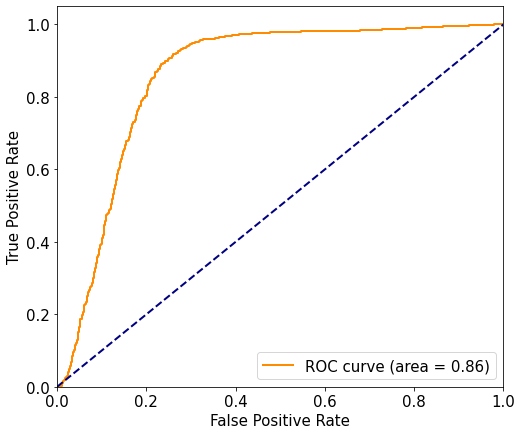

In [16]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    data_test=x_test_client_transpose, label_test=test_labels[0].values)
plot_roc(test_labels[0].values, y_prediction)

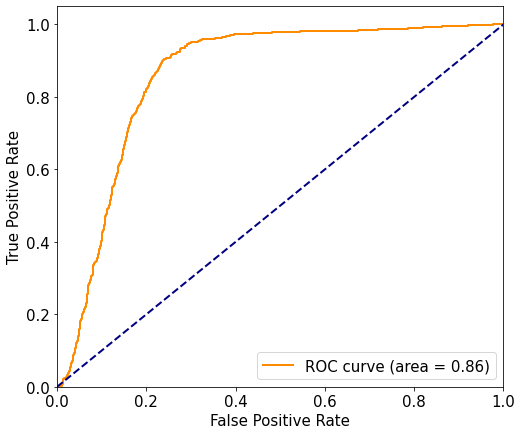

In [34]:
# Linear model Benchmark on centralized data using sk-learn:
#clf_linear = MLPClassifier(hidden_layer_sizes=(1,), max_iter=10000, shuffle=False, random_state=321).fit(x_train, y_train)

centralized_train_data = np.concatenate(
    [x_train_client[key].to_numpy() for key in x_train_client], axis=1)
centralized_test_data = np.concatenate(
    [x_test_client[key].to_numpy() for key in x_train_client], axis=1)

clf_linear = LogisticRegression(random_state=123).fit(centralized_train_data, train_labels[0].values)

y_prediction = clf_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels[0].values, y_prediction)

**Non-linear model:**

We now add a hidden layer in the clients' neural network model, resulting in a *non-linear* model (parameter `layer_dims=[3]`): 

In [38]:
model_nodes = [VerticalNeuralNetClient(n_features=x_train_client[0].shape[1], 
                                       layer_dims=[3]),
               VerticalNeuralNetClient(n_features=x_train_client[1].shape[1], 
                                       layer_dims=[3])]

federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [39]:
federated_government.run_rounds(n=100001, 
                                test_data=x_test_client_transpose, 
                                test_label=test_labels[0].values, 
                                print_freq=10000)

Round 0
Collaborative model train loss: 0.6991631647727085
Distributed model test AUC: 0.5070363754588434


Round 10000
Collaborative model train loss: 0.671304668562445
Distributed model test AUC: 0.7202214626007412


Round 20000
Collaborative model train loss: 0.5121982577056645
Distributed model test AUC: 0.8554177402085646


Round 30000
Collaborative model train loss: 0.43834303366676575
Distributed model test AUC: 0.8565782099254604


Round 40000
Collaborative model train loss: 0.4257968560138984
Distributed model test AUC: 0.8576742337944248


Round 50000
Collaborative model train loss: 0.4232068431103168
Distributed model test AUC: 0.8586671443066981




KeyboardInterrupt: 

As before, we can compare the performance to the analogous centralized model using one hidden layer: 

Distributed model test AUC: 0.8587413681453507


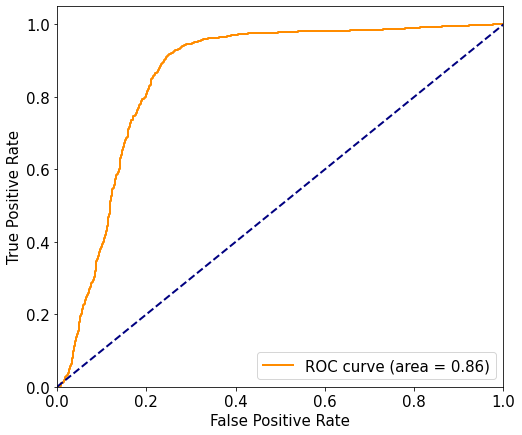

In [31]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    data_test=x_test_client_transpose, label_test=test_labels[0].values)
plot_roc(test_labels[0].values, y_prediction)

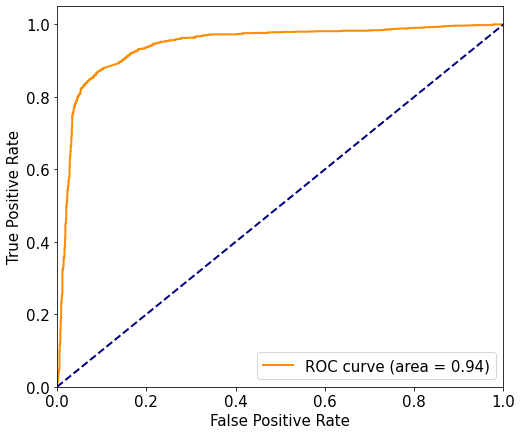

In [37]:
# Non-linear benchmark
clf_non_linear = MLPClassifier(hidden_layer_sizes=(3,), max_iter=10000, 
                               shuffle=False, random_state=3221)
clf_non_linear.fit(centralized_train_data, train_labels[0].values)

y_prediction = clf_non_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels[0].values, y_prediction)